In [ ]:
import torch
from torch import nn

device = "cuda" #if torch.cuda.is_available() else "cpu"
device

In [ ]:
import os

train_dir = "/home/uam/HamdahM/training_set"
test_dir = "/home/uam/HamdahM/test_set"
new_test_dir = "/home/uam/HamdahM/test_set_new"
train_dir, test_dir, new_test_dir

In [ ]:
image_path = "/home/uam/HamdahM"

In [ ]:
import random
from PIL import Image
import glob
from pathlib import Path

# Set seed
random.seed(42) 

# 1. Get all image paths (* means "any combination")
image_path_list= glob.glob(f"{image_path}/*/*/*.jpg")

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = Path(random_image_path).parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to IMAGE_SIZE xIMAGE_SIZE 
    transforms.Resize(size=IMAGE_SIZE),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {Path(random_image_path).parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform, n=3)

In [ ]:
from torchvision import datasets

# Creating training set
train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=data_transform, 
                                  target_transform=None) 
#Creating test set
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

In [ ]:
class_names = train_data.classes
class_dict = train_data.class_to_idx

In [ ]:
img, label = train_data[0][0], train_data[0][1]
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [ ]:
from torch.utils.data import DataLoader

# How many subprocesses will be used for data loading (higher = more)
NUM_WORKERS = os.cpu_count()

# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=NUM_WORKERS,
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

train_dataloader, test_dataloader

In [ ]:
img, label = next(iter(train_dataloader))

# Set image size.
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Create training transform with TrivialAugment
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()])

In [ ]:
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
test_data_augmented = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_augmented

In [ ]:
BATCH_SIZE = 32
torch.manual_seed(42)

train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_augmented = DataLoader(test_data_augmented, 
                                       batch_size=BATCH_SIZE, 
                                       shuffle=False, 
                                       num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_augmented

In [ ]:
import torch
import torch.nn as nn


class ImageClassifierv2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
          nn.Conv2d(3, 64, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(2))
        self.conv_layer_2 = nn.Sequential(
          nn.Conv2d(64, 128, 3, padding=1),  # Reduced to 128 from 512
          nn.ReLU(),
          nn.BatchNorm2d(128),
          nn.MaxPool2d(2))
        self.conv_layer_3 = nn.Sequential(
          nn.Conv2d(128, 256, 3, padding=1),  # New layer for gradual increase
          nn.ReLU(),
          nn.BatchNorm2d(256),
          nn.MaxPool2d(2))
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global Avg Pooling
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Dropout(0.5),  # Added dropout
          nn.Linear(in_features=256, out_features=2))

    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.global_avg_pool(x)  # Replace flattening with GAP
        x = self.classifier(x)
        return x

model = ImageClassifierv2().to(device)

In [ ]:
img_batch, label_batch = next(iter(train_dataloader_augmented))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))

print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

In [ ]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               adv_lr = 1.0):
    
    # Setup train loss, adverserial loss and train accuracy values
    train_adv_loss, train_loss, train_acc = 0, 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        mu = X.mean(dim=[2, 3], keepdim=True)
        var = X.var(dim=[2, 3], keepdim=True)
        sig = (var + 1e-5).sqrt()
        mu, sig = mu.detach(), sig.detach()
        input_normed = (X - mu) / sig
        input_normed = input_normed.detach().clone()
        # Set learnable style feature and adv optimizer
        adv_mu, adv_sig = mu, sig
        adv_mu.requires_grad_(True)
        adv_sig.requires_grad_(True)
        adv_optim = torch.optim.SGD(params=[adv_mu, adv_sig], lr=adv_lr, momentum=0, weight_decay=0)
        # Optimize adversarial style feature
        adv_optim.zero_grad()
        adv_input = input_normed * adv_sig+ adv_mu
        adv_output = model(adv_input)
        adv_loss = loss_fn(adv_output, y)
        train_adv_loss += adv_loss.item()
        (- adv_loss).backward()
        adv_optim.step()
        

        model.train()
        optimizer.zero_grad()
        adv_input = input_normed * adv_sig + adv_mu
        inputs = torch.cat((X, adv_input), dim=0)
        gt = torch.cat((y, y), dim=0)
        outputs = model(inputs)
        loss = loss_fn(outputs, gt)
        train_loss+= loss.item()
        loss.backward()
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(adv_output, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(adv_output)

    adv_loss = adv_loss / len(dataloader)
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_adv_loss, train_acc, train_loss


In [ ]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "adv_loss": []
    }

    for epoch in tqdm(range(epochs)):
        adv_loss, train_acc, train_loss = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"adv_loss: {adv_loss:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["adv_loss"].append(adv_loss)

    # 6. Return the filled results at the end of the epochs
    return results

In [ ]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1.0)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_results = train(model=model,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_augmented,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
def plot_loss_curves(results):
  
    results = dict(list(model_results.items()))

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plot_loss_curves(model_results)

In [ ]:
# Choose a image.
custom_image_path = "/home/uam/HamdahM/test_set/cats/cat.4017.jpg"

import torchvision
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

In [ ]:
custom_image_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

In [ ]:
model.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model(custom_image_transformed.unsqueeze(dim=0).to(device))

In [ ]:
custom_image_pred

In [ ]:

print(f"Prediction logits: {custom_image_pred}")

custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

In [ ]:
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

In [ ]:
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False)

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


In [ ]:
model.eval()

image_path = "/home/uam/HamdahM/test_set/cats/cat.4017.jpg"

custom_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

custom_image = custom_image / 255

custom_image_transformed = custom_image_transform(custom_image)



In [ ]:
custom_image_transformed.requires_grad = True
output = model(custom_image_transformed.unsqueeze(dim=0).to(device))
predicted_label = torch.argmax(output, 1).item()
predicted_label

In [ ]:
true_label = torch.tensor([0]).to(device)

loss = torch.nn.CrossEntropyLoss()(output, true_label)

In [ ]:
model.zero_grad()
loss.backward()
data_grad = custom_image_transformed.grad.data

In [ ]:
epsilon = 0.125
perturbed_image = fgsm_attack(custom_image_transformed, epsilon, data_grad)

In [ ]:
output = model(perturbed_image.unsqueeze(dim=0).to(device))
new_predicted_label = torch.argmax(output, 1).item()

In [ ]:
image_np = np.transpose(custom_image_transformed.squeeze().detach().numpy(), (1, 2, 0))
perturbed_image_np = np.transpose(perturbed_image.squeeze().detach().numpy(), (1, 2, 0))

In [ ]:
def show_image_label(image, label):
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)
    plt.show()

In [ ]:
show_image_label(image_np, f"Orignal Label: {predicted_label}")
show_image_label(perturbed_image_np, f"Adverserial Label: {new_predicted_label}")

/home/uam/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/uam/.local/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


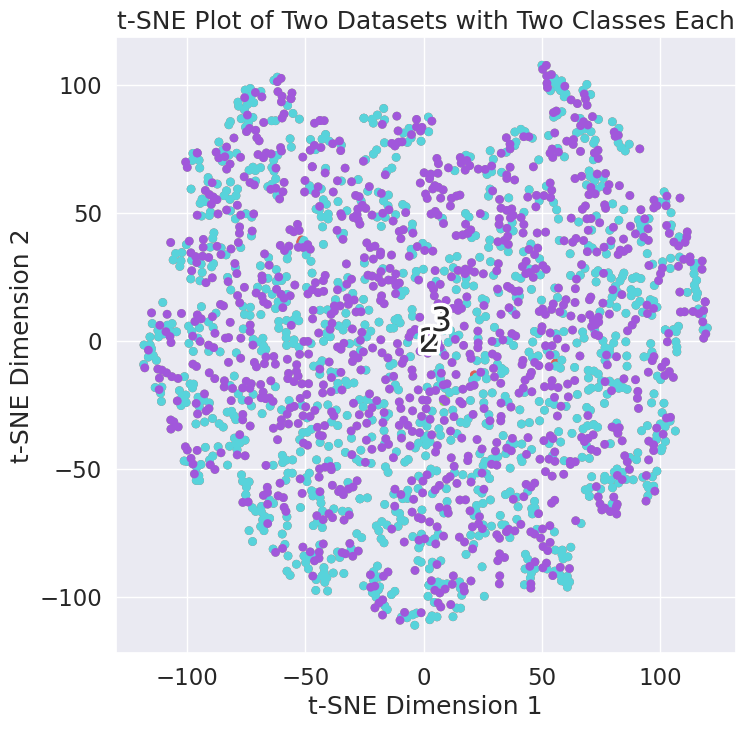

In [120]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.manifold import TSNE

# So that you won't get the OpenMP related warning
os.environ["OMP_NUM_THREADS"] = "1"

# Set image size.
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
test_transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor()
    ]
)

dataset_1 = datasets.ImageFolder(test_dir, transform=test_transform)  # usual cats and dogs dataset
dataset_2 = datasets.ImageFolder(new_test_dir, transform=test_transform)  # the one I gave you with modified images
dataloader_1 = DataLoader(dataset_1, batch_size=1, shuffle=False, num_workers=NUM_WORKERS)
dataloader_2 = DataLoader(dataset_2, batch_size=1, shuffle=False, num_workers=NUM_WORKERS)


# Assuming you have a DataLoader object named 'dataloader'
# Iterate over the DataLoader to get batches of data
def t_sne(dataloader1: torch.utils.data.DataLoader, dataloader2: torch.utils.data.DataLoader):
    all_X = []
    all_y = []

    for batch_idx, (X_batch, y_batch) in enumerate(dataloader1):
        # This time already is numpy as we don't have to_tensor in the transform
        X = X_batch.numpy()
        # compute the channel-wise mean and standard deviation
        mean = X.mean(axis =(0, 2, 3)) 
        std = X.std(axis =(0, 2, 3))
        y = y_batch.numpy()
        # add mean and std to one list
        mean_std = np.concatenate([mean, std])
        all_X.append(mean_std)
        all_y.append(y)

    for batch_idx, (X_batch, y_batch) in enumerate(dataloader2):
        X = X_batch.numpy()
        mean = X.mean(axis  =(0, 2, 3))
        std = X.std(axis =(0, 2, 3))
        y = y_batch.numpy()
        # We will add 2 to the labels of the second dataset to distinguish them
        y += 2
        mean_std = np.concatenate([mean, std])
        all_X.append(mean_std)
        all_y.append(y)

    all_X = np.vstack(all_X)
    all_y = np.hstack(all_y)


    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=20)
    X_tsne = tsne.fit_transform(all_X)
    # Define colors
    import matplotlib.pyplot as plt
    import matplotlib.patheffects as PathEffects
    import matplotlib
    %matplotlib inline
    
    # We import seaborn to make nice plots.
    import seaborn as sns
    sns.set_style('darkgrid')
    sns.set_palette('muted')
    sns.set_context("notebook", font_scale=1.5,
                    rc={"lines.linewidth": 2.5})
    
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 4))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(X_tsne[:,0], X_tsne[:,1], lw=0, s=40,
                    c=palette[all_y.astype(np.int64)])
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(X_tsne[all_y == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    
    plt.title("t-SNE Plot of Two Datasets with Two Classes Each")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")

    plt.grid(True)
    plt.show()


t_sne(dataloader_1, dataloader_2)
